Universidade Estadual de Campinas – UNICAMP 

Disciplina: Ciência e Visualização de Dados em Saúde

                    Análise de dados da hanseníase: uma abordagem preditiva para a saúde pública

# Imports e configs de módulos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import imageio
from IPython.display import Image
import warnings
from sklearn.feature_selection import f_classif, mutual_info_classif
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 70)
%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.005)
warnings.filterwarnings('ignore')
pd.__version__

'2.0.2'

# Datasets

In [3]:
df_hans = pd.read_csv('../data/interim/hans_pre_covid.csv')

In [62]:
df_hans.head()

,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,ANO_NASC,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_OCUPA_N,FORMACLINI,AVALIA_N,CLASSOPERA,MODODETECT,BACILOSCOP,DTINICTRAT,ESQ_INI_N,UFATUAL,ID_MUNI_AT,DT_NOTI_AT,ID_UNID_AT,UFRESAT,MUNIRESAT,CLASSATUAL,AVAL_ATU_N,ESQ_ATU_N,EPIS_RACIO,NU_ANO,NU_LESOES,CONTREG,DOSE_RECEB,CONTEXAM,DTALTA_N,TPALTA_N
0,29.0,292700,1382.0,2653257.0,27/11/2008,1958.0,M,6.0,4.0,3.0,29.0,292700.0,1382.0,NaN,2.0,3.0,1.0,2.0,3.0,02/03/2009,1.0,BA,292700.0,01/01/2009,2653257.0,29.0,292700.0,1.0,3.0,1.0,4.0,2009,1.0,4.0,6.0,NaN,29/12/2009,1.0
1,21.0,210330,1434.0,2449706.0,01/01/2009,1943.0,M,6.0,4.0,1.0,21.0,210330.0,1434.0,NaN,4.0,1.0,2.0,1.0,1.0,23/10/2009,2.0,MA,210330.0,01/01/2009,2449706.0,21.0,210330.0,2.0,1.0,2.0,4.0,2009,10.0,6.0,12.0,1.0,22/09/2010,1.0
2,26.0,260290,1497.0,20389.0,13/10/2008,1994.0,F,9.0,NaN,NaN,26.0,260290.0,1497.0,999991.0,1.0,0.0,1.0,1.0,2.0,13/10/2008,1.0,PE,260290.0,02/01/2009,20389.0,26.0,260290.0,1.0,NaN,1.0,NaN,2009,1.0,3.0,NaN,3.0,22/05/2009,1.0
3,21.0,211290,1432.0,2455706.0,02/01/2009,1957.0,M,6.0,1.0,2.0,21.0,211290.0,1432.0,NaN,4.0,3.0,2.0,2.0,1.0,02/01/2009,2.0,MA,211290.0,02/01/2009,2455706.0,21.0,211290.0,2.0,3.0,2.0,4.0,2009,2.0,6.0,12.0,1.0,29/04/2010,1.0
4,35.0,354350,1575.0,2053381.0,18/12/2008,1968.0,M,6.0,1.0,1.0,35.0,354350.0,1575.0,NaN,1.0,0.0,2.0,1.0,1.0,18/12/2008,2.0,SP,354350.0,02/01/2009,2053381.0,35.0,354350.0,2.0,1.0,2.0,4.0,2009,1.0,2.0,NaN,2.0,18/12/2009,1.0


In [4]:
df_hans.shape

(309555, 38)

In [5]:
# Remove datas inconsistentes
try:
  df_hans['DTINICTRAT'] = pd.to_datetime(df_hans['DTINICTRAT'], dayfirst=True)
  df_hans['DTALTA_N'] = pd.to_datetime(df_hans['DTALTA_N'], dayfirst=True, format='mixed')
except ValueError:
    df_hans['DTINICTRAT'] = pd.to_datetime(df_hans['DTINICTRAT'], dayfirst=True, errors='coerce')
    df_hans['DTALTA_N'] = pd.to_datetime(df_hans['DTALTA_N'], dayfirst=True, errors='coerce')

df_hans['DURACAO_TRAT'] = (df_hans['DTALTA_N'] - df_hans['DTINICTRAT']).dt.days
df_hans = df_hans[df_hans['DURACAO_TRAT'] >= 0]
print(df_hans.shape)

(309524, 39)


# EDA

### Análise de casos por estado

In [7]:
df_hans_states = df_hans['UFATUAL'].value_counts().to_frame().reset_index()
df_hans_states = df_hans_states.rename(columns={'UFATUAL': 'UF', 'count': 'Contagem'})
df_hans_states.head()

,UF,Contagem
0,MA,13597
1,PA,11551
2,MT,11462
3,PE,9437
4,BA,8618


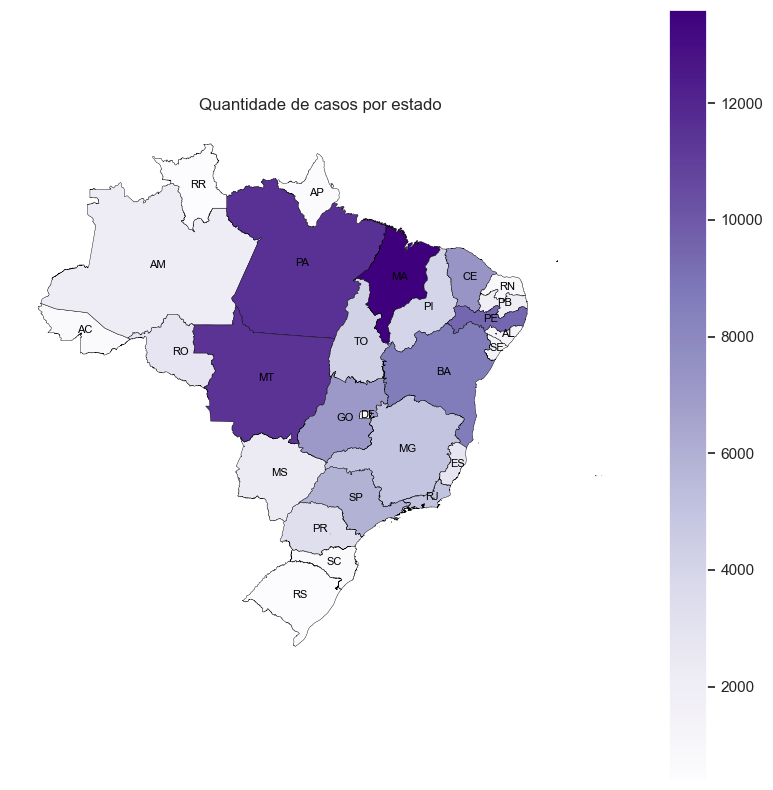

In [8]:
# Carrega o arquivo shapefile do mapa do Brasil
map = gpd.read_file('../assets/mapa/BR_UF_2022.shp')

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences = map.merge(df_hans_states, left_on='SIGLA_UF', right_on='UF')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos por estado')
ax.set_axis_off()
plt.show()

### Análise de casos por estado e por ano

In [9]:
df_hans_states_per_year = df_hans[['UFATUAL', 'NU_ANO']].value_counts().to_frame().reset_index()
df_hans_states_per_year = df_hans_states_per_year.rename(columns={'UFATUAL': 'UF', 'count': 'Contagem'})
df_hans_states_per_year.head()

,UF,NU_ANO,Contagem
0,MT,2018,1570
1,MT,2019,1481
2,MA,2010,1418
3,MA,2009,1396
4,PA,2009,1391


In [10]:
years_analysis = df_hans_states_per_year['NU_ANO'].unique()
years_analysis.sort()

vmax=df_hans_states_per_year['Contagem'].max()

In [11]:
for i in range(len(years_analysis)):
    year = years_analysis[i]
    # Combina o DataFrame com o GeoDataFrame do mapa
    map_occurrences = map.merge(df_hans_states_per_year[df_hans_states_per_year['NU_ANO']==year], left_on='SIGLA_UF', right_on='UF')
    map_occurrences.drop(['NU_ANO'], axis=1, inplace=True)
    map_occurrences.fillna(0, inplace=True)

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    map_occurrences.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True, vmin=0, vmax=vmax)

    # Adiciona as siglas das UFs
    for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
        ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')
    
    ax.set_title('Quantidade de casos por estado em {}'.format(year))
    ax.set_axis_off()
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for i in range(len(years_analysis)):
    year = years_analysis[i]
    nome_arquivo = f'../assets/graficos/mapa_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos.gif', imagens, fps=2)

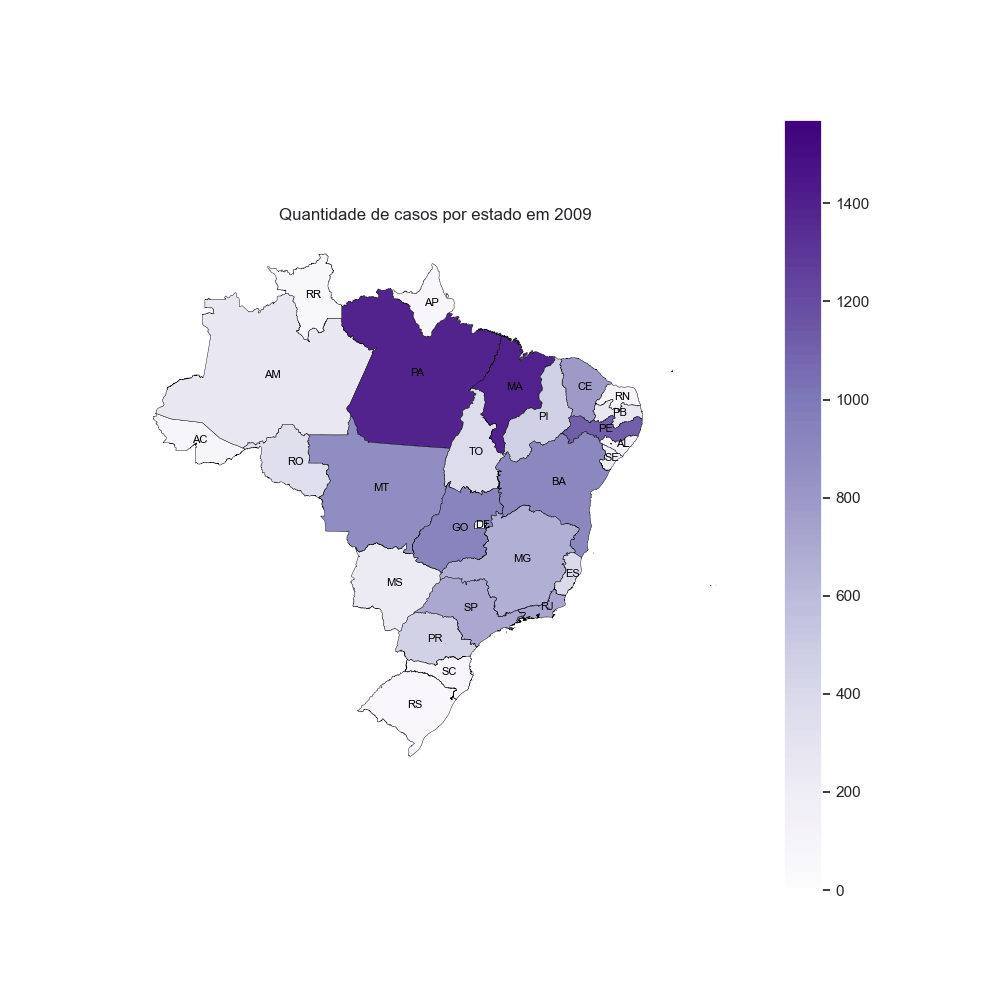

In [12]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos.gif')


### Correlação da quantidade de casos e o IDH dos estados

#### 1. Sem remover outliers

In [13]:
df_idh = pd.read_csv('../data/interim/idh_interim.csv')
df_idh['IDH'] = df_idh['IDH'].astype(float)
df_idh.head()

,UF,NU_ANO,IDH
0,AC,2009,0.663
1,AL,2009,0.631
2,AP,2009,0.708
3,AM,2009,0.674
4,BA,2009,0.660


In [14]:
df_hans_idh = pd.merge(df_hans_states_per_year, df_idh, on=['UF', 'NU_ANO'], how='inner')
df_hans_idh.head()

,UF,NU_ANO,Contagem,IDH
0,MT,2018,1570,0.778
1,MT,2019,1481,0.779
2,MA,2010,1418,0.639
3,MA,2009,1396,0.639
4,PA,2009,1391,0.646


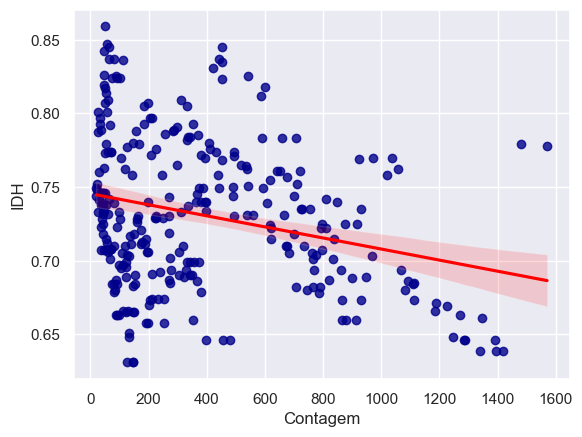

In [15]:
# Cria o gráfico de dispersão com linha de regressão
sns.regplot(x='Contagem', y='IDH', data=df_hans_idh, color='darkblue', line_kws={'color': 'red'})

# Exibe o gráfico
plt.show()

In [16]:
# Calcule a correlação entre as variáveis
correlation = df_hans_idh['Contagem'].corr(df_hans_idh['IDH'])
# Imprima o resultado
print('Correlação:', correlation)

# Calcule a covariância entre as variáveis
covariance = df_hans_idh['Contagem'].cov(df_hans_idh['IDH'])
# Imprima o resultado
print('Covariância:', covariance)


Correlação: -0.2662809553881988
Covariância: -4.833880835380835


### Análise de casos por estado e gravidade

In [17]:
df_hans_severity = df_hans.groupby(['UFATUAL', 'AVALIA_N']).size().reset_index(name='Contagem')
df_hans_severity.head()

,UFATUAL,AVALIA_N,Contagem
0,AC,0.0,511
1,AC,1.0,106
2,AC,2.0,40
3,AC,3.0,9
4,AL,0.0,698


#### Grau 0:

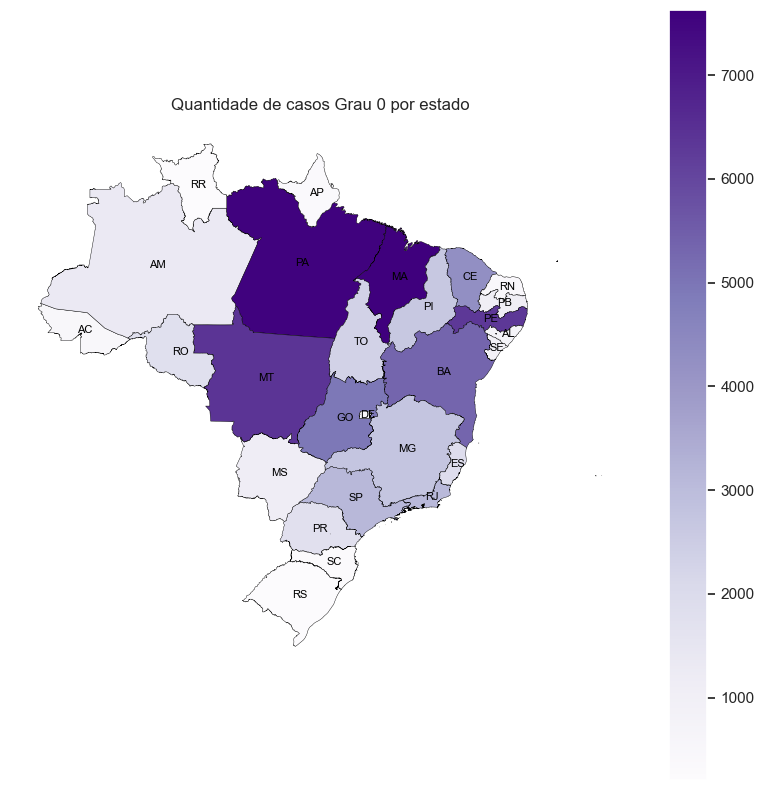

In [18]:
df_hans_severity_0 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 0].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_0 = map.merge(df_hans_severity_0, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_0.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau 0 por estado')
ax.set_axis_off()
plt.show()

#### Grau I:

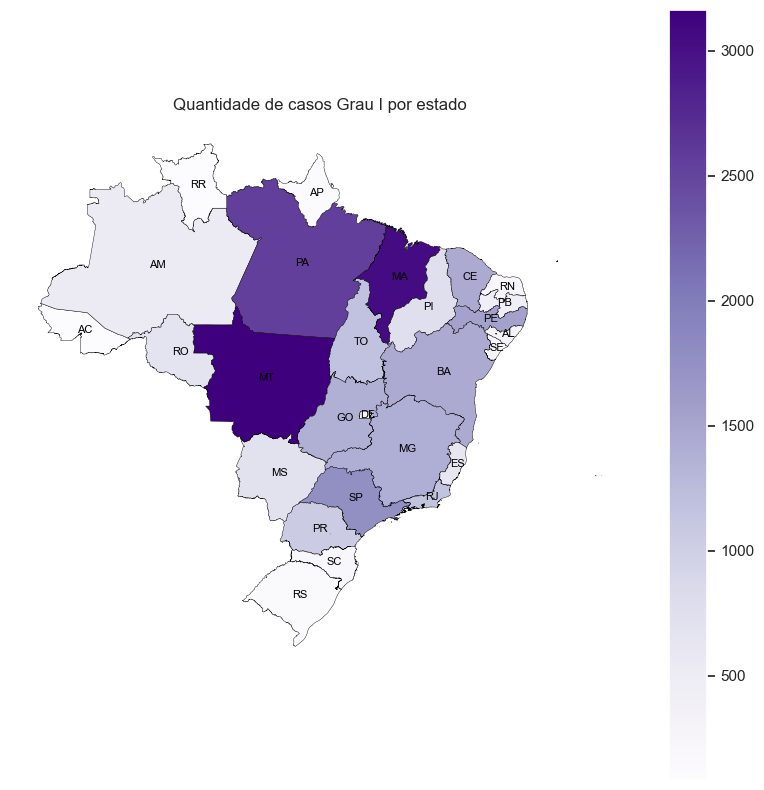

In [19]:

df_hans_severity_1 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 1].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_1 = map.merge(df_hans_severity_1, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_1.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau I por estado')
ax.set_axis_off()
plt.show()

#### Grau II:

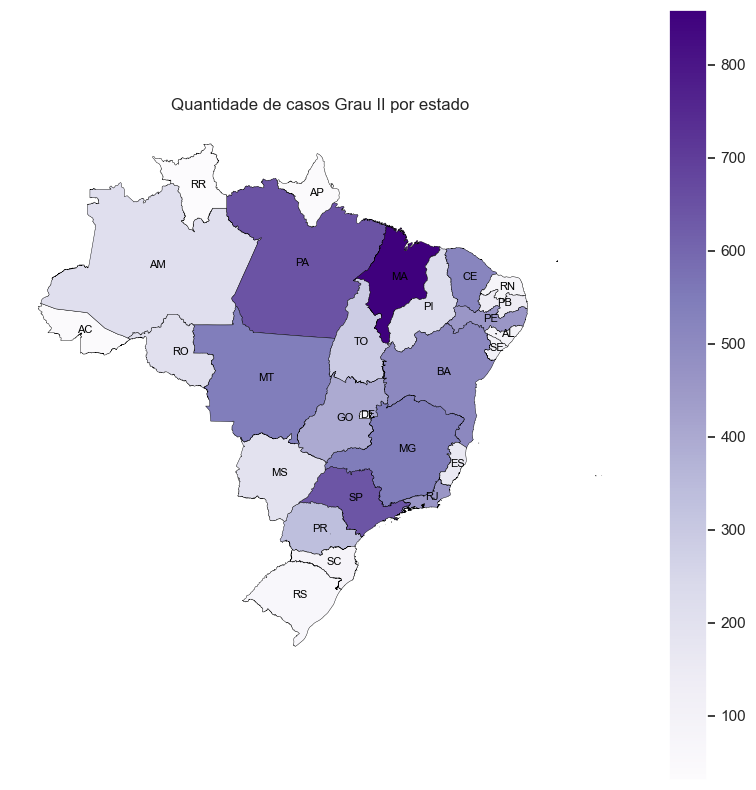

In [20]:
df_hans_severity_2 = df_hans_severity.loc[df_hans_severity['AVALIA_N'] == 2].drop('AVALIA_N', axis=1)

# Combina o DataFrame com o GeoDataFrame do mapa
map_occurrences_2 = map.merge(df_hans_severity_2, left_on='SIGLA_UF', right_on='UFATUAL')

# Plot do mapa do Brasil com os dados
fig, ax = plt.subplots(figsize=(10, 10))
map_occurrences_2.plot(column='Contagem', cmap='Purples', edgecolor='black', linewidth = 0.3, ax=ax, legend=True)

# Adiciona as siglas das UFs
for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
    ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')

ax.set_title('Quantidade de casos Grau II por estado')
ax.set_axis_off()
plt.show()

### Análise do abandono

In [6]:
# Considerar apenas casos com desfecho: cura, óbito ou abandono
df_hans_tp_alta = df_hans[df_hans['TPALTA_N'].isin([1, 6, 7])]

In [7]:
df_hans_outcome = df_hans_tp_alta.copy()
df_hans_outcome.shape

(309524, 39)

In [8]:
df_hans_outcome['TPALTA_N'] = df_hans_outcome['TPALTA_N'].replace({1: 'Cura', 6: 'Óbito', 7: 'Abandono'})
df_hans_outcome.head()

,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,ANO_NASC,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_OCUPA_N,FORMACLINI,AVALIA_N,CLASSOPERA,MODODETECT,BACILOSCOP,DTINICTRAT,ESQ_INI_N,UFATUAL,ID_MUNI_AT,DT_NOTI_AT,ID_UNID_AT,UFRESAT,MUNIRESAT,CLASSATUAL,AVAL_ATU_N,ESQ_ATU_N,EPIS_RACIO,NU_ANO,NU_LESOES,CONTREG,DOSE_RECEB,CONTEXAM,DTALTA_N,TPALTA_N,DURACAO_TRAT
0,29.0,292700,1382.0,2653257.0,27/11/2008,1958.0,M,6.0,4.0,3.0,29.0,292700.0,1382.0,NaN,2.0,3.0,1.0,2.0,3.0,2009-03-02,1.0,BA,292700.0,01/01/2009,2653257.0,29.0,292700.0,1.0,3.0,1.0,4.0,2009,1.0,4.0,6.0,NaN,2009-12-29,Cura,302
1,21.0,210330,1434.0,2449706.0,01/01/2009,1943.0,M,6.0,4.0,1.0,21.0,210330.0,1434.0,NaN,4.0,1.0,2.0,1.0,1.0,2009-10-23,2.0,MA,210330.0,01/01/2009,2449706.0,21.0,210330.0,2.0,1.0,2.0,4.0,2009,10.0,6.0,12.0,1.0,2010-09-22,Cura,334
2,26.0,260290,1497.0,20389.0,13/10/2008,1994.0,F,9.0,NaN,NaN,26.0,260290.0,1497.0,999991.0,1.0,0.0,1.0,1.0,2.0,2008-10-13,1.0,PE,260290.0,02/01/2009,20389.0,26.0,260290.0,1.0,NaN,1.0,NaN,2009,1.0,3.0,NaN,3.0,2009-05-22,Cura,221
3,21.0,211290,1432.0,2455706.0,02/01/2009,1957.0,M,6.0,1.0,2.0,21.0,211290.0,1432.0,NaN,4.0,3.0,2.0,2.0,1.0,2009-01-02,2.0,MA,211290.0,02/01/2009,2455706.0,21.0,211290.0,2.0,3.0,2.0,4.0,2009,2.0,6.0,12.0,1.0,2010-04-29,Cura,482
4,35.0,354350,1575.0,2053381.0,18/12/2008,1968.0,M,6.0,1.0,1.0,35.0,354350.0,1575.0,NaN,1.0,0.0,2.0,1.0,1.0,2008-12-18,2.0,SP,354350.0,02/01/2009,2053381.0,35.0,354350.0,2.0,1.0,2.0,4.0,2009,1.0,2.0,NaN,2.0,2009-12-18,Cura,365


<Axes: ylabel='TPALTA_N'>

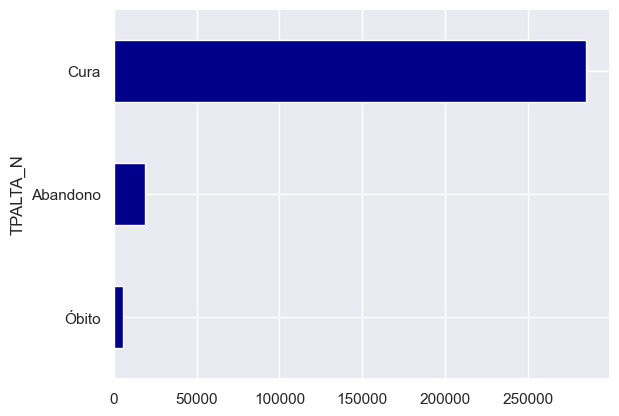

In [9]:
df_hans_outcome['TPALTA_N'].value_counts().sort_values().plot.barh(color='darkblue')

In [25]:
# Agrupa os dados pelo ano e pelo munícipio da ultima atualização
gp_muni_at = df_hans.groupby(["NU_ANO", "ID_MUNI_AT"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_muni_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_muni_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = count_ab/count_diag
count_df

DT_DIAG  ABANDONOS  PERCENT_AB
NU_ANO ID_MUNI_AT                                
2009   110001.0         10          0    0.000000
       110002.0         27          0    0.000000
       110004.0         10          1    0.100000
       110005.0          3          1    0.333333
       110006.0          7          0    0.000000
...                    ...        ...         ...
2019   522150.0          4          0    0.000000
       522160.0          7          1    0.142857
       522180.0          1          0    0.000000
       522205.0          2          0    0.000000
       530010.0         50          9    0.180000

[21171 rows x 3 columns]

In [26]:
# Leitura dos polígonos das cidades brasileiras de uma cópia local
geo = gpd.read_file("../assets/mapa/all_cities.shp")
# Adapta o código das cidades do ibge para a versão utilizada pelo ministério da saúde 
geo["muni"] = geo["code_muni"].astype("string").str.slice(stop=-3).astype("float64")

for year in years_analysis:
    # Combina as contagens de abandono por cidade com o GeoDataFrame do mapa
    map_occurrences = geo.merge(count_df.loc[[year]], how="left", left_on=["muni"], right_on=["ID_MUNI_AT"])

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    map_occurrences.plot(
        column='PERCENT_AB', cmap='winter_r', edgecolor='black', linewidth = 0.1, ax=ax, legend=True, 
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": "Percentagem de abandono", "orientation": "horizontal", "shrink": 0.6}
    )
    ax.set_title('Porcentagem de abandono em relação ao número de diagnósticos em {}'.format(year))
    ax.set_axis_off()
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_ab_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for year in years_analysis:
    nome_arquivo = f'../assets/graficos/mapa_ab_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos_ab.gif', imagens, fps=2)

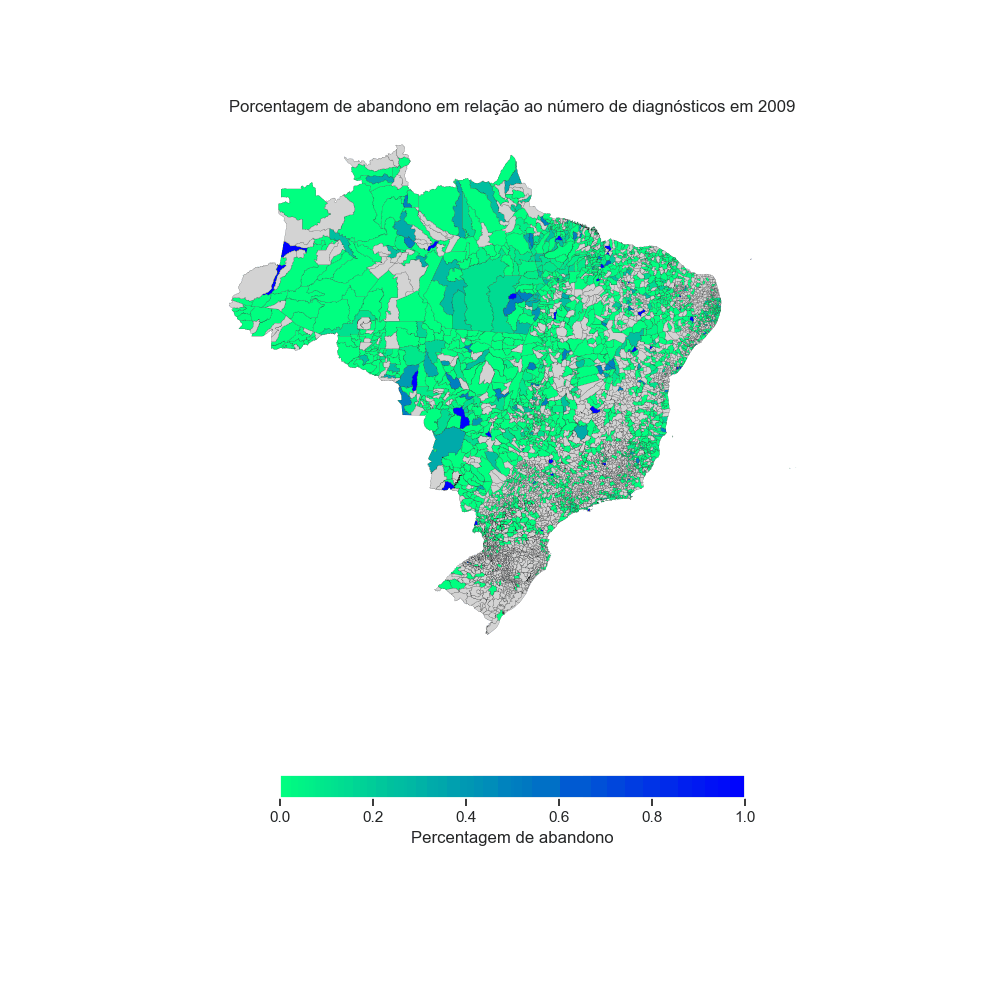

In [27]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos_ab.gif')

In [28]:
# Agrupar abandonos por estado
gp_uf_at = df_hans.groupby(["NU_ANO", "UFATUAL"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_uf_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_uf_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = count_ab/count_diag
count_df

DT_DIAG  ABANDONOS  PERCENT_AB
NU_ANO UFATUAL                                
2009   AC            90          0    0.000000
       AL           126         10    0.079365
       AM           254         16    0.062992
       AP            70         13    0.185714
       BA           913         69    0.075575
...                 ...        ...         ...
2019   RS            26          2    0.076923
       SC            48          2    0.041667
       SE           109          5    0.045872
       SP           451         25    0.055432
       TO           543         40    0.073665

[297 rows x 3 columns]

In [29]:
# Leitura dos polígonos dos estados brasileiros de uma cópia local
geo = gpd.read_file("../assets/mapa/BR_UF_2022.shp")

# Max e Min dos valores
vmin = min(count_df["PERCENT_AB"])
vmax = max(count_df["PERCENT_AB"])

for year in years_analysis:    
    # Combina as contagens de abandono por estado com o GeoDataFrame do mapa
    map_occurrences = geo.merge(count_df.loc[[year]], how="left", left_on=["SIGLA_UF"], right_on=["UFATUAL"])

    # Plot do mapa do Brasil com os dados
    fig, ax = plt.subplots(figsize=(10, 10))
    heatmap = map_occurrences.plot(
        column='PERCENT_AB', cmap='winter_r', edgecolor='black', linewidth = 0.3, ax=ax, legend=True, 
        missing_kwds={"color": "lightgrey", "label": "Sem dados"},
        legend_kwds={"label": "Percentagem de abandono", "orientation": "horizontal", "shrink": 0.6},
        vmin=vmin, vmax=vmax
    )
    ax.set_title('Porcentagem de abandono em relação ao número de diagnósticos em {}'.format(year))
    ax.set_axis_off()
    
    # Adiciona as siglas das UFs
    for x, y, label in zip(map_occurrences.geometry.centroid.x, map_occurrences.geometry.centroid.y, map_occurrences['SIGLA_UF']):
        ax.annotate(label, xy=(x, y), xytext=(2, -2), textcoords="offset points", ha='center', fontsize=8, color='black')
    
    # Salva a imagem com o nome do ano
    plt.savefig('../assets/graficos/mapa_ab_uf_{}.png'.format(year))
    plt.close()
    
# usar a biblioteca imageio para criar o gif a partir das imagens salvas
imagens = []
for year in years_analysis:
    nome_arquivo = f'../assets/graficos/mapa_ab_uf_{year}.png'
    imagem = imageio.imread(nome_arquivo)
    imagens.append(imagem)

# criar o gif a partir das imagens
imageio.mimsave('../assets/graficos/graficos_ab_uf.gif', imagens, fps=2)

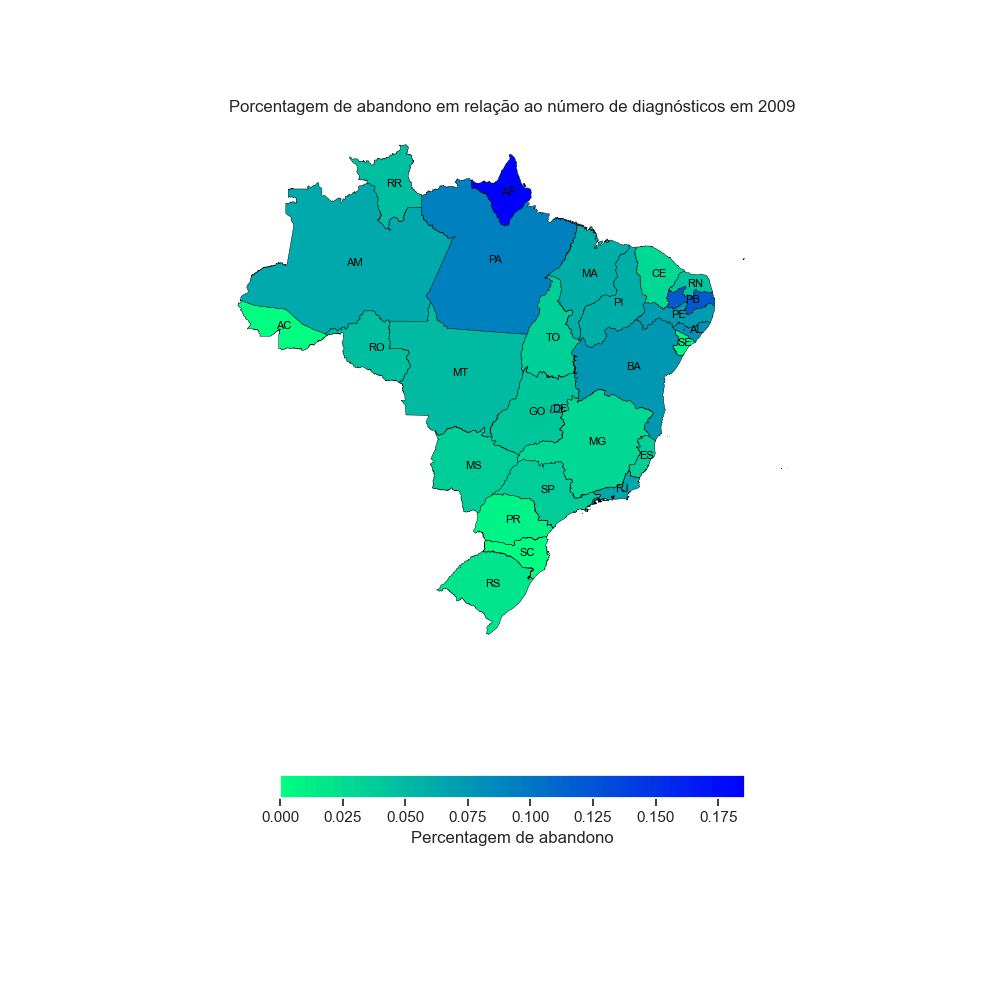

In [30]:
# Exibe o GIF dos casos em cada estado por ano
Image(filename='../assets/graficos/graficos_ab_uf.gif')

In [31]:
# Agrupar abandonos por sexo
gp_mf_at = df_hans.groupby(["NU_ANO", "CS_SEXO"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_mf_at['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_mf_at['DT_DIAG'].count()
count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = (count_ab/count_diag)*100
count_df = count_df.drop('I', level='CS_SEXO')
count_df

DT_DIAG  ABANDONOS  PERCENT_AB
NU_ANO CS_SEXO                                
2009   F           5839        323    5.531769
       M           7215        399    5.530146
2010   F           5161        255    4.940903
       M           6736        348    5.166271
2011   F           5211        248    4.759163
       M           6585        282    4.282460
2012   F           4861        240    4.937256
       M           6206        333    5.365775
2013   F           5004        280    5.595524
       M           6220        354    5.691318
2014   F           4816        263    5.460963
       M           5885        336    5.709431
2015   F           4161        275    6.608988
       M           5456        356    6.524927
2016   F           3718        241    6.481980
       M           4843        322    6.648771
2017   F           3890        281    7.223650
       M           4822        294    6.097055
2018   F           4349        269    6.185330
       M           5309        374    7.044641
2019   F           4161        349    8.387407
       M           5164        457    8.849729

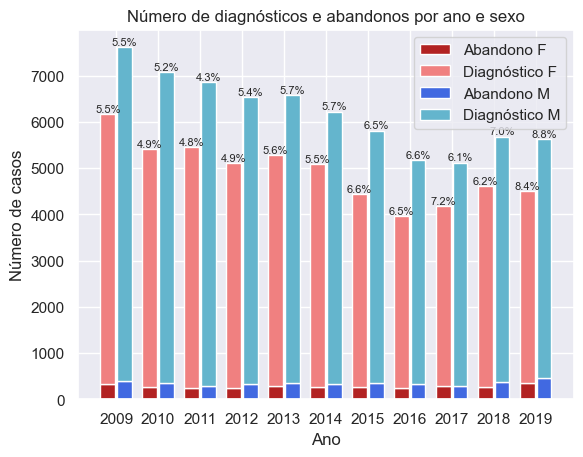

In [32]:
years = count_df.index.get_level_values('NU_ANO').unique()
sexes = count_df.index.get_level_values('CS_SEXO').unique()

bar_width = 0.35
r = np.arange(len(years))
spacing = [0.15-bar_width, -0.15+bar_width]
colors = [['lightcoral', 'firebrick'], ['c', 'royalblue']]
legend_handles = list()

for i, year in enumerate(years):
    for j, sex in enumerate(sexes):
        aband_bar = plt.bar(r[i] + spacing[j], 
                            count_df['ABANDONOS'].loc[year, sex], 
                            width=bar_width, color=colors[j][1],
                            label=f"Abandonos {sex}")
        legend_handles.append(aband_bar[0])
        
        diag_bar = plt.bar(r[i] + spacing[j], 
                           count_df['DT_DIAG'].loc[year, sex], 
                           width=bar_width, color=colors[j][0], 
                           label=f"Diagnóstico {sex}",
                           bottom=count_df['ABANDONOS'].loc[year, sex])
        legend_handles.append(diag_bar[0])
        
        total = count_df['ABANDONOS'].loc[year, sex] + count_df['DT_DIAG'].loc[year, sex]
        plt.text(r[i] + spacing[j], total, 
                 f'{count_df["PERCENT_AB"].loc[year,sex]:.1f}%', 
                 ha='center', va='bottom', fontsize=8)
    
plt.xlabel("Ano")
plt.ylabel("Número de casos")
plt.title("Número de diagnósticos e abandonos por ano e sexo")

plt.xticks(r, years)
plt.legend(handles=legend_handles, labels=['Abandono F',
                                           'Diagnóstico F',
                                           'Abandono M',
                                           'Diagnóstico M'])
plt.savefig('../assets/graficos/graficos_ab_sexo.png')
plt.show()

In [33]:
df_hans['IDADE'] = df_hans['NU_ANO'] - df_hans['ANO_NASC']
df_hans['FAIXA_ETARIA'] = np.round(df_hans['IDADE']/10)*10
gp_idade = df_hans.groupby(["FAIXA_ETARIA"], group_keys=False)
# Conta o número de abandonos
count_ab = gp_idade['TPALTA_N'].apply(lambda x: (x==7).sum())
# Conta o número de diagnósticos
count_diag = gp_idade['DT_DIAG'].count()

count_df = pd.DataFrame(count_diag)
count_df["ABANDONOS"] = count_ab
count_df["PERCENT_AB"] = (count_ab/count_diag)*100
count_df

,DT_DIAG,ABANDONOS,PERCENT_AB
FAIXA_ETARIA,,,
0.0,446,12,2.690583
10.0,6758,296,4.379994
20.0,12654,1197,9.459459
30.0,15944,1310,8.216257
40.0,22486,1484,6.599662
50.0,19621,972,4.953876
60.0,20541,890,4.332798
70.0,10153,378,3.723038
80.0,5029,218,4.334858


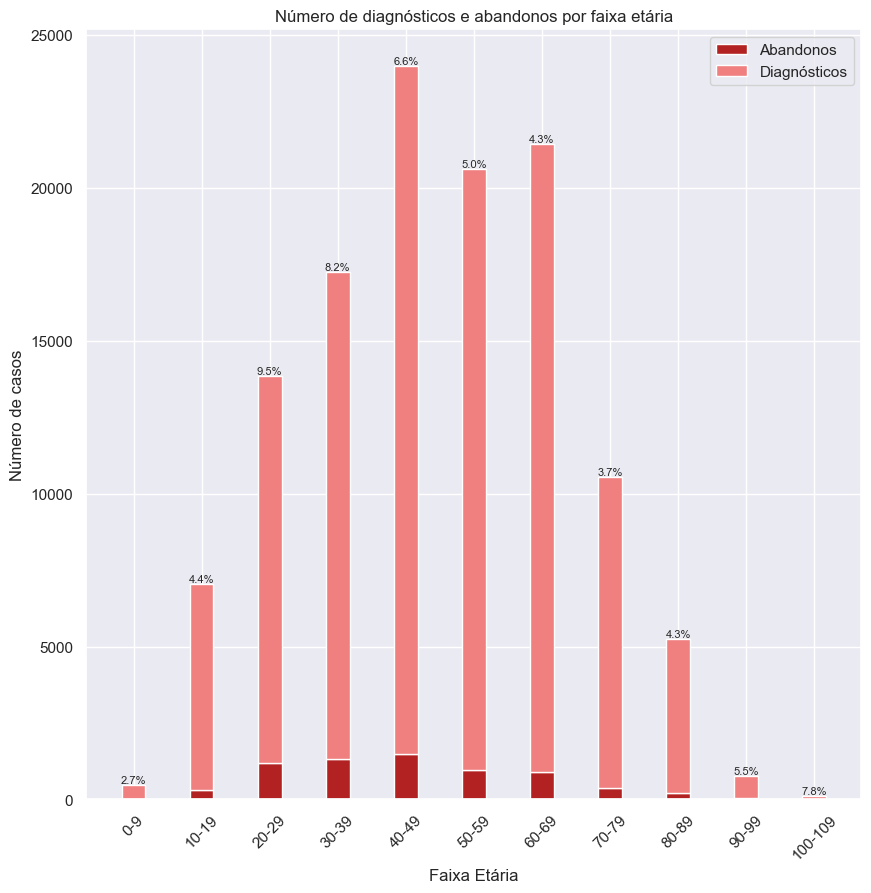

In [34]:
years = count_df.index.get_level_values('FAIXA_ETARIA').unique()[:-1]

bar_width = 0.35
r = np.arange(len(years))
colors = ['lightcoral', 'firebrick']
legend_handles = list()

plt.figure(figsize=(10,10))
for i, year in enumerate(years):
    aband_bar = plt.bar(r[i], 
                        count_df['ABANDONOS'].loc[year], 
                        width=bar_width, color=colors[1],
                        label="Abandonos")
    legend_handles.append(aband_bar[0])
    
    diag_bar = plt.bar(r[i],
                       count_df['DT_DIAG'].loc[year], 
                       width=bar_width, color=colors[0], 
                       label="Diagnósticos",
                       bottom=count_df['ABANDONOS'].loc[year])
    legend_handles.append(diag_bar[0])
    
    total = count_df['ABANDONOS'].loc[year] + count_df['DT_DIAG'].loc[year]
    plt.text(r[i], total, 
             f'{count_df["PERCENT_AB"].loc[year]:.1f}%', 
             ha='center', va='bottom', fontsize=8)
    
plt.xlabel("Faixa Etária")
plt.ylabel("Número de casos")
plt.title("Número de diagnósticos e abandonos por faixa etária")
plt.xticks(r, ['0-9', '10-19', '20-29', '30-39', '40-49',
            '50-59', '60-69', '70-79', '80-89', '90-99', '100-109'])
plt.xticks(rotation=45)

plt.legend(handles=legend_handles, labels=['Abandonos',
                                           'Diagnósticos'])
plt.savefig('../assets/graficos/graficos_ab_idade.png')
plt.show()

### Correlação variáveis

#### Tempo de Cura

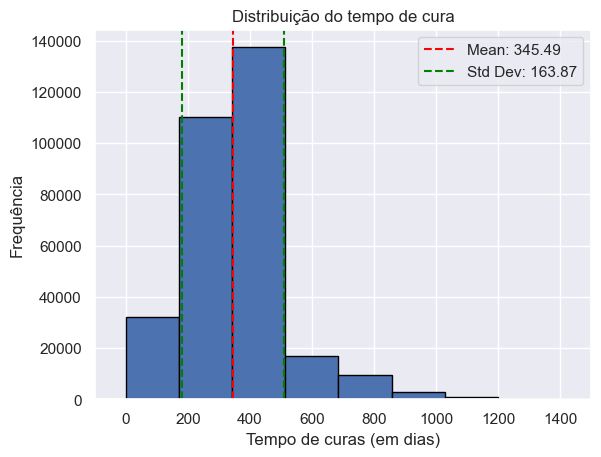

In [10]:
# Análise da distribuição dos tempos de cura
column_name = 'DURACAO_TRAT'
filtered_data = df_hans[df_hans[column_name] >= 0][column_name]

mean = np.mean(filtered_data)
std_dev = np.std(filtered_data)


plt.hist(filtered_data, bins=50, edgecolor='black')
plt.xlabel('Tempo de curas (em dias)')
plt.ylabel('Frequência')
plt.title('Distribuição do tempo de cura')
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean:.2f}')
plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1.5, label=f'Std Dev: {std_dev:.2f}')
plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=1.5)
plt.legend()

x_min = -100 
x_max = 1500
plt.xlim(x_min, x_max)

plt.show()

In [11]:
column_name = 'DURACAO_TRAT' 
correlation = df_hans.corr()[column_name]
print(correlation)

ValueError: could not convert string to float: '27/11/2008'

#####
Note que as correlações mais altas se dão, em ordem decrescente, com as colunas:

CLASSOPERA (0.461423) - classificação operacional, virável categórica para 1 = paucibacilar, 2 = multibacilar

FORMACLINI (0.366289) - forma clínica da doença, variável categórica para 1 = indeterminada, 2 = tuberculóide, 3 = dimorfa, 4 = virchowiana, 5 = não classficado

NU_LESOES (0.210927) - número de lesões

#### Tipo de Saída

In [12]:
cols_to_change = [elem for elem in df_hans_outcome.columns if 'ID_' in elem or 'CS_' in elem or 'UF' in elem or 'MUNI' in elem]
others_cols = ['FORMACLINI', 'AVALIA_N', 'CLASSOPERA', 'MODODETECT', 'BACILOSCOP', 'ESQ_INI_N', 'CLASSATUAL', 
                'AVAL_ATU_N', 'ESQ_ATU_N', 'EPIS_RACIO', 'TPALTA_N']
cols_to_change = cols_to_change + others_cols
df_hans_outcome[cols_to_change] = df_hans_outcome[cols_to_change].astype(str)
df_hans_outcome.shape

(309524, 39)

In [19]:
df_hans_outcome = df_hans_outcome[df_hans_outcome['TPALTA_N'] != 'Óbito']
df_hans_outcome.to_csv('../data/interim/hans_outcome.csv', index=False)
df_hans_outcome.head()

,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_DIAG,ANO_NASC,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_OCUPA_N,FORMACLINI,AVALIA_N,CLASSOPERA,MODODETECT,BACILOSCOP,DTINICTRAT,ESQ_INI_N,UFATUAL,ID_MUNI_AT,DT_NOTI_AT,ID_UNID_AT,UFRESAT,MUNIRESAT,CLASSATUAL,AVAL_ATU_N,ESQ_ATU_N,EPIS_RACIO,NU_ANO,NU_LESOES,CONTREG,DOSE_RECEB,CONTEXAM,DTALTA_N,TPALTA_N,DURACAO_TRAT
0,29.0,292700,1382.0,2653257.0,27/11/2008,1958.0,M,6.0,4.0,3.0,29.0,292700.0,1382.0,nan,2.0,3.0,1.0,2.0,3.0,2009-03-02,1.0,BA,292700.0,01/01/2009,2653257.0,29.0,292700.0,1.0,3.0,1.0,4.0,2009,1.0,4.0,6.0,NaN,2009-12-29,Cura,302
1,21.0,210330,1434.0,2449706.0,01/01/2009,1943.0,M,6.0,4.0,1.0,21.0,210330.0,1434.0,nan,4.0,1.0,2.0,1.0,1.0,2009-10-23,2.0,MA,210330.0,01/01/2009,2449706.0,21.0,210330.0,2.0,1.0,2.0,4.0,2009,10.0,6.0,12.0,1.0,2010-09-22,Cura,334
2,26.0,260290,1497.0,20389.0,13/10/2008,1994.0,F,9.0,nan,nan,26.0,260290.0,1497.0,999991.0,1.0,0.0,1.0,1.0,2.0,2008-10-13,1.0,PE,260290.0,02/01/2009,20389.0,26.0,260290.0,1.0,nan,1.0,nan,2009,1.0,3.0,NaN,3.0,2009-05-22,Cura,221
3,21.0,211290,1432.0,2455706.0,02/01/2009,1957.0,M,6.0,1.0,2.0,21.0,211290.0,1432.0,nan,4.0,3.0,2.0,2.0,1.0,2009-01-02,2.0,MA,211290.0,02/01/2009,2455706.0,21.0,211290.0,2.0,3.0,2.0,4.0,2009,2.0,6.0,12.0,1.0,2010-04-29,Cura,482
4,35.0,354350,1575.0,2053381.0,18/12/2008,1968.0,M,6.0,1.0,1.0,35.0,354350.0,1575.0,nan,1.0,0.0,2.0,1.0,1.0,2008-12-18,2.0,SP,354350.0,02/01/2009,2053381.0,35.0,354350.0,2.0,1.0,2.0,4.0,2009,1.0,2.0,NaN,2.0,2009-12-18,Cura,365


In [14]:
# Selecionando features
target = 'TPALTA_N'
num_feats = [col for col in df_hans_outcome.columns if df_hans_outcome[col].dtype != 'O']
cat_feats = [col for col in df_hans_outcome.columns if col not in num_feats]

cat_feats = [feat for feat in cat_feats if 'DT' not in feat if target not in feat if 'ID' not in feat if 'ESCOL' not in feat]
num_feats = [feat for feat in num_feats if 'DT' not in feat if 'CONT' not in feat]

cat_to_remove = ['SG_UF_NOT', 'UFRESAT', 'MUNIRESAT', 'UFATUAL', 'CLASSATUAL', 'AVAL_ATU_N', 'ESQ_ATU_N', 'EPIS_RACIO']
for feat in cat_to_remove:
    cat_feats.remove(feat)
print(cat_feats)

['CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'SG_UF', 'FORMACLINI', 'AVALIA_N', 'CLASSOPERA', 'MODODETECT', 'BACILOSCOP', 'ESQ_INI_N']


### ML Tests

In [15]:
num_transformer = FeatureUnion(    
    [
        ('num_pipe', Pipeline(
            [
                ('norm', StandardScaler()),
                ('nan_input', SimpleImputer())
            ]
        )),
        ('nan_flag', MissingIndicator(error_on_new=False))
    ]
)
feat_transformer = ColumnTransformer(
    [
        ('num_trans', num_transformer, num_feats),
        ('cat_trans', OneHotEncoder(handle_unknown='ignore'), cat_feats)    
    ],
    remainder='passthrough', sparse_threshold=0
)

In [16]:
X = df_hans_outcome[num_feats + cat_feats].copy()
le = LabelEncoder().fit(df_hans_outcome['TPALTA_N'])
y = le.transform(df_hans_outcome['TPALTA_N'])
X.shape

(304142, 15)

#### Random Forest

In [17]:
rf_pipe = Pipeline([('feat_trans', feat_transformer),
                    ('over', SMOTE()),
                    ('rf', RandomForestClassifier(n_estimators=100))
                   ])

In [18]:
preds = cross_val_predict(rf_pipe, X, y, cv=5)
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64     18644
           1       0.98      0.98      0.98    285498

    accuracy                           0.96    304142
   macro avg       0.82      0.80      0.81    304142
weighted avg       0.96      0.96      0.96    304142



#### Logistic Regression

In [20]:
lr_pipe = Pipeline([('feat_trans', feat_transformer),
                    ('over', SMOTE()),
                    ('rf', LogisticRegression(max_iter=100))
                   ])

In [21]:
preds = cross_val_predict(lr_pipe, X, y, cv=5)
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.40      0.87      0.55     18644
           1       0.99      0.92      0.95    285498

    accuracy                           0.91    304142
   macro avg       0.70      0.89      0.75    304142
weighted avg       0.95      0.91      0.93    304142

